# Example for open_FRED weather data download

This example shows you how to download open_FRED weather data from the [OpenEnergy DataBase](https://openenergy-platform.org/dataedit/) and store it locally. Furthermore, it shows how to convert the weather data to the format needed by the `pvlib`and `windpowerlib` using the `feedinlib`.

* [Download data for single coordinate](#single_loc)
* [Download data for a region](#region)
* [Convert data into pvlib and windpowerlib format](#convert)

In [3]:
from shapely.geometry import Point, Polygon

from feedinlib.open_FRED import Weather
from feedinlib.open_FRED import defaultdb

## Download data for single coordinate <a class="anchor" id="single_loc"></a>

To download data for a single location you have to specify a shapely Point with longitude and latitude of the desired location. Data will be retrieved for the nearest weather data point to that location.

In [6]:
location = Point(13.30, 52.47)

Besides a location you have to specify a time period for which you would like to download the data as well as the weather variables you need. The feedinlib provides predefined sets of variables that are needed to use the pvlib and windpowerlib. These can be applied by setting the `variables` parameter to "pvlib" or "windpowerlib", as shown below.

Concerning the start and end date, keep in mind that all timestamps in the `feedinlib` are in UTC. So if you later on want to convert the data to a different time zone, the data may not cover the whole period you intended to download. To avoid this set your start date to one day before the start of your required period if you are East of the zero meridian or your end date to one day after your required period ends if you are West of the zero meridian.

In [3]:
# download data for July 2017 (end date will not be included in the 
# time period for which data is downloaded)
start_date, end_date = '2017-07-01', '2017-08-01'
# set variables set to download
variables = "windpowerlib"

As the open_FRED weather dataset provides some variables at different heights, such as wind speed and air pressure, it is possible to define which heights you want to retrieve the data for.

In [4]:
heights = [100, 140]

Now we can retrieve the data:

In [5]:
open_FRED_weather_windpowerlib_single_location = Weather(
    start=start_date, stop=end_date, locations=[location],
    heights=heights,
    variables=variables,
    **defaultdb())

The `Weather` object can be stored and later reloaded using the `to_csv` and `from_csv` functions:

In [4]:
#open_FRED_weather_windpowerlib_single_location.to_csv(
    #'open_FRED_weather_windpowerlib_single_location')
open_FRED_weather_windpowerlib_single_location = Weather.from_csv(
    'open_FRED_weather_windpowerlib_single_location')

## Download data for a region<a class="anchor" id="region"></a>

In this example we will retrieve weather data needed for pvlib calculations. We can do this by setting `variables` to "pvlib". In this case specifying the heights for which to retrieve the data is not necessary as irradiance data is only available at the surface and 10m wind speed is used per default.

**<font color=red>The following code may take a while to execute!</font>**

In [12]:
# read provided shape file
import geopandas as gpd
region_shape = gpd.read_file('berlin_shape.geojson')

open_FRED_weather_pvlib_region = Weather(
    start='2017-01-01', stop='2018-01-01', 
    locations=[], 
    regions=[region_shape.geometry.values[0]],
    variables="pvlib",
    **defaultdb())

AttributeError: 'Location' object has no attribute 'x'

## Convert data into pvlib and windpowerlib format<a class="anchor" id="convert"></a>

In order to use the weather data for your feed-in calculations using the pvlib and windpowerlib it has to be converted into the required format. This is done using the `df` method of the `Weather` class. 
The dataframe can only be created for a single location, which is also how it is required by the pvlib and windpowerlib. You therefore always have to provide a shapely Point with longitude and latitude of the desired location.

Let's first plot the downloaded weather data points for the region on a map.

In [33]:
# get all downloaded weather data points
from geoalchemy2.shape import to_shape

points = [to_shape(location.point)
  for locations in open_FRED_weather_pvlib_berlin.regions.values()
  for location in locations
]
points_df = gpd.GeoDataFrame({'geometry': points})

# plot weather data points on map
base = region_shape.plot(color='white', edgecolor='black')
points_df.plot(ax=base, marker='o', color='red', markersize=5);

In [7]:
# convert to windpowerlib dataframe
windpowerlib_df = open_FRED_weather_windpowerlib_single_location.df(
    location=location,
    lib="windpowerlib")

In [ ]:
# convert to pvlib dataframe
pvlib_df = open_FRED_weather_pvlib_region.df(
    location=location,
    lib="pvlib")

In [43]:
pvlib_df.to_csv('open_FRED_Dahlem_2017.csv')

The following shows you in short how to use the weather data for feed-in calculations and mainly serves as a test wether the conversion works correctly. More detailed explanation on feed-in calculations using the feedinlib can be found in the notebooks `run_pvlib_model.ipynb` and `run_windpowerlib_turbine_model.ipynb`.

In [ ]:
from feedinlib import Photovoltaic
system_data = {
    'module_name': 'Advent_Solar_Ventura_210___2008_', 
    'inverter_name': 'ABB__MICRO_0_25_I_OUTD_US_208__208V_',
    'azimuth': 180,
    'tilt': 30,
    'albedo': 0.2}
pv_system = Photovoltaic(**system_data)
feedin = pv_system.feedin(
    weather=pvlib_df,
    location=(52.4, 13.2))
feedin.plot()

/home/birgit/virtualenvs/feedinlib_openmod/lib/python3.6/site-packages/pandas/core/arrays/datetimes.py:1269: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  UserWarning,


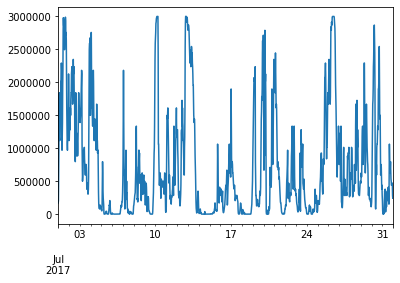

In [8]:
from feedinlib import WindPowerPlant
turbine_data = {
    'turbine_type': 'E-101/3050',
    'hub_height': 135
    }
wind_turbine = WindPowerPlant(**turbine_data)
feedin = wind_turbine.feedin(
    weather=windpowerlib_df)
feedin.plot()